<a href="https://colab.research.google.com/github/talhaanwarch/ODIR2019/blob/master/vgg_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#connect drive with colab notebook/

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


https://github.com/keras-team/keras/issues/8130
https://stackoverflow.com/questions/56796331/how-to-input-multiple-images-with-flow-from-dataframe-in-keras

In [2]:
#following are libraries to unpack 7z file
!pip install patool 
!pip install pyunpack
from pyunpack import Archive

     |████████████████████████████████| 81kB 7.7MB/s 
  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5162 sha256=cb0a898aedc9720ff15a55fd6a00dcb2def219a183d13139bf9e0a9c0a15a1cc
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack


In [0]:
import pandas as pd
import numpy as np
import cv2

In [0]:

#create a folder name as data
!mkdir data

In [0]:
#path where our data is saved
path='/content/drive/My Drive/ghina/thesis/'

In [0]:
#extract the 7z file in data folder we created above
#this not only extract the data but move it from drive to colab for efficinet processing
#it will take some time
Archive(path+'ODIR-5K_Training_Images.7z').extractall('data')

In [0]:
#read the annottion file
annotation=pd.read_excel(path+'ODIR-5K_Training_Annotations(Updated)_V2.xlsx')

In [0]:

#normal (N), diabetes (D), glaucoma (G), cataract (C), AMD (A), hypertension (H), myopia (M) and other diseases/abnormalities (O)

In [9]:
#print first 5 rows of annotation file
annotation=annotation.sample(frac=1)
annotation.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
1016,1034,56,Male,1034_left.jpg,1034_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
3317,4475,66,Male,4475_left.jpg,4475_right.jpg,normal fundus,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
1311,1471,45,Male,1471_left.jpg,1471_right.jpg,glaucoma,epiretinal membrane,0,0,1,0,0,0,0,1
1608,2147,55,Female,2147_left.jpg,2147_right.jpg,cataract,refractive media opacity,0,0,0,1,0,0,0,1
847,849,60,Female,849_left.jpg,849_right.jpg,hypertensive retinopathy,hypertensive retinopathy,0,0,0,0,0,1,0,0


In [0]:
train_annotation=annotation[0:2500]
val_annotation=annotation[2500:3500]


In [11]:
train_annotation.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
1016,1034,56,Male,1034_left.jpg,1034_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
3317,4475,66,Male,4475_left.jpg,4475_right.jpg,normal fundus,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
1311,1471,45,Male,1471_left.jpg,1471_right.jpg,glaucoma,epiretinal membrane,0,0,1,0,0,0,0,1
1608,2147,55,Female,2147_left.jpg,2147_right.jpg,cataract,refractive media opacity,0,0,0,1,0,0,0,1
847,849,60,Female,849_left.jpg,849_right.jpg,hypertensive retinopathy,hypertensive retinopathy,0,0,0,0,0,1,0,0


In [0]:
for i in ['G',	'C',	'A',	'H',	'M']:
  duplicate=train_annotation[train_annotation[i]==1]
  train_annotation=train_annotation.append([duplicate]*3,ignore_index=True)

In [0]:

# train_annotation.drop(columns=['ID', 'Patient Age', 'Patient Sex','Left-Diagnostic Keywords', 'Right-Diagnostic Keywords'],inplace=True)
# val_annotation.drop(columns=['ID', 'Patient Age', 'Patient Sex','Left-Diagnostic Keywords', 'Right-Diagnostic Keywords'],inplace=True)

# def change_name(x):
#   l=list(x)
#   l.insert(l.index('_'),'_1')
#   l=''.join(l)
#   return l
# def df_row_duplicate(df):
#   for i in range(len(df)):
#     left=change_name(df.iloc[i,0]) #creat new image name

#     img_left=Image.open('/content/data/ODIR-5K_Training_Dataset/{}'.format(df.iloc[i,0]))
#     img_left = img_left.save('/content/data/ODIR-5K_Training_Dataset/{}'.format(img_left)) 

#     right=change_name(df.iloc[i,1])
#     img_right=Image.open('/content/data/ODIR-5K_Training_Dataset/{}'.format(df.iloc[i,1]))
#     img_right = img_right.save('/content/data/ODIR-5K_Training_Dataset/{}'.format(img_right)) 

#     label=list(df.iloc[i,-8::])
#     new_list=[left,right]+label
#     df=df.append(pd.Series(new_list,index=['Left-Fundus',	'Right-Fundus','N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O']),ignore_index=True)
#   return df

In [14]:
len(train_annotation)

4618

In [0]:
img_shape=256*2

In [0]:
#https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [0]:
def load_ben_color(image, sigmaX=10):
    #image = cv2.imread(path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (img_shape, img_shape))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    
    
    return image

In [0]:
from keras_preprocessing.image import ImageDataGenerator

train_data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    preprocessing_function=load_ben_color
)

val_data_gen= ImageDataGenerator(
    rescale=1/255
    
)

In [0]:
batch_size=20
def get_flow_from_dataframe(generator, dataframe,directory_path,
                            image_shape=(img_shape, img_shape),
                            #subset='training',
                             batch_size=batch_size):
    train_generator_1 = generator.flow_from_dataframe(dataframe,
                                                      directory=directory_path,
                                                      target_size=(img_shape,img_shape),
                                                      x_col="Left-Fundus",
                                                      y_col=['N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O'],
                                                      class_mode='other',
                                                      shuffle=False,
                                                      batch_size=batch_size,
                                                      seed=7,
                                                      #subset=subset
                                                      )

    train_generator_2 = generator.flow_from_dataframe(dataframe, 
                                                      directory=directory_path,
                                                      target_size=(img_shape,img_shape),
                                                      x_col="Right-Fundus",
                                                      y_col=['N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O'],
                                                      class_mode='other',
                                                      shuffle=False,
                                                      batch_size=batch_size,
                                                      seed=7,
                                                      #subset=subset
                                                      )
    while True:
        x_1 = train_generator_1.next()
        x_2 = train_generator_2.next()

        yield [x_1[0], x_2[0]], x_1[1]

In [20]:
train_generator_1 = train_data_gen.flow_from_dataframe(train_annotation,
                                                  directory="data/ODIR-5K_Training_Dataset/",
                                                  target_size=(img_shape,img_shape),
                                                  x_col="Left-Fundus",
                                                  y_col=['N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O'],
                                                  class_mode='other',
                                                  shuffle=False,
                                                  batch_size=batch_size,
                                                  seed=7,
                                                  #subset=subset
                                                  )

Found 4618 validated image filenames.


In [21]:
train_generator_1.next()[0].shape

(20, 512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


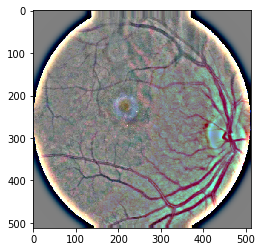

In [22]:
import matplotlib.pyplot as plt
plt.imshow(train_generator_1.next()[0][1])

In [0]:
batch_size=50
train_gen = get_flow_from_dataframe(train_data_gen, train_annotation, image_shape=(img_shape, img_shape),
                                        directory_path="data/ODIR-5K_Training_Dataset/",batch_size=batch_size)
valid_gen = get_flow_from_dataframe(val_data_gen, val_annotation, image_shape=(img_shape, img_shape),
                                        directory_path="data/ODIR-5K_Training_Dataset/",batch_size=batch_size)

In [24]:
img_shape

512

In [25]:
from keras.models import Sequential,Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from keras.layers import GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

import keras
left_input=Input(shape=(img_shape,img_shape,3))
right_input=Input(shape=(img_shape,img_shape,3))

left_model = VGG16(input_shape =  (img_shape,img_shape,3), include_top = False, weights = 'imagenet')
right_model = VGG16(input_shape =  (img_shape,img_shape,3), include_top = False, weights = 'imagenet')

left_model.trainable = False
right_model.trainable = False

In [91]:
pt_depth = left_model.get_output_shape_at(0)[-1]
pt_depth

512

In [0]:
left_model_features = left_model(left_input)
right_model_features = right_model(right_input)
# left_model_features=left_model.output
# right_model_features=right_model.output

In [0]:
left_bn_features = BatchNormalization()(left_model_features)
right_bn_features = BatchNormalization()(right_model_features)


In [0]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
def attention(bn):
  attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn)
  attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
  attn_layer = LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
  up_c2_w = np.ones((1, 1, 1, pt_depth))
  up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
  up_c2.trainable = False
  attn_layer = up_c2(attn_layer)
  mask_features = multiply([attn_layer, bn])
  gap_features = GlobalAveragePooling2D()(mask_features)
  gap_mask = GlobalAveragePooling2D()(attn_layer)
  # to account for missing values from the attention model
  gap = Lambda(lambda x: x[0]/x[1])([gap_features, gap_mask])

  return gap

In [0]:
left_atten=attention(left_bn_features)
right_atten=attention(right_bn_features)

In [0]:
con = concatenate([left_atten, right_atten])
gap_dr = Dropout(0.5)(con)
dr_steps = Dropout(0.25)(gap_dr)
fc=Dense(128, activation = 'elu')(dr_steps)
out = Dense(8, activation = 'sigmoid')(dr_steps)


In [0]:

for layer in right_model.layers:
        layer.name = layer.name + '_right'
for layer in left_model.layers:
  layer.name = layer.name + '_left'

left_model.name="left_vgg16"
right_model.name="right_vgg16"

In [0]:
model =Model(inputs=[left_input, right_input], outputs=out)


In [99]:
left_model.summary()

Model: "left_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3_left (InputLayer)    (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1_left (Conv2D)   (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2_left (Conv2D)   (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool_left (MaxPooling (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1_left (Conv2D)   (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2_left (Conv2D)   (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool_left (MaxPooling (None, 128, 128, 128)     0

In [0]:
import keras.backend as K
def focal_loss(y_true, y_pred, alpha = 0.75, gamma = 3):
  alpha_factor = K.ones_like(y_true) * alpha
  alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
  focal_weight = tf.where(K.equal(y_true, 1), 1 - y_pred, y_pred)
  focal_weight = alpha_factor * focal_weight ** gamma
  loss = focal_weight * K.binary_crossentropy(y_true, y_pred)
  return loss

In [0]:
model.compile('Adadelta',loss=focal_loss,metrics=['accuracy'])

In [0]:
step_size_train=len(train_annotation)/batch_size
step_size_val=len(val_annotation)/batch_size


In [0]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1)

In [31]:
model.fit_generator(train_gen, epochs=5,
                        steps_per_epoch=step_size_train,
                        use_multiprocessing=True,
                        validation_data=valid_gen,
                        validation_steps=step_size_val,
                        verbose=2,callbacks=[reduce_lr]
                   # class_weight=[0.5,0.5,1.5,1.5,1.5,2.5,1.5,0.5]
                    
                        )

Epoch 1/5
Found 1000 validated image filenames.
Found 1000 validated image filenames.
Found 4561 validated image filenames.
Found 4561 validated image filenames.
 - 1702s - loss: 0.0259 - acc: 0.3448 - val_loss: 0.0316 - val_acc: 0.0410
Epoch 2/5
 - 1607s - loss: 0.0252 - acc: 0.3129 - val_loss: 0.0320 - val_acc: 0.0410
Epoch 3/5
 - 1626s - loss: 0.0250 - acc: 0.3159 - val_loss: 0.0300 - val_acc: 0.0410
Epoch 4/5
 - 1626s - loss: 0.0241 - acc: 0.3396 - val_loss: 0.0292 - val_acc: 0.0410
Epoch 5/5
 - 1645s - loss: 0.0238 - acc: 0.3407 - val_loss: 0.0298 - val_acc: 0.0520


In [32]:
y_pred = model.predict_generator(valid_gen,steps=step_size_val)


Found 1000 validated image filenames.
Found 1000 validated image filenames.


In [0]:
y_pred1=y_pred.copy()
y_pred1[y_pred1>=0.3] = 1
y_pred1[y_pred1<0.3] = 0
y_pred1=y_pred1.astype(int)

In [40]:
y_true=val_annotation.iloc[:,-8::].values
y_true.shape

(1000, 8)

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_true, y_pred1)

array([[[  0, 697],
        [  0, 303]],

       [[  0, 651],
        [  0, 349]],

       [[  0, 930],
        [  0,  70]],

       [[  0, 942],
        [  0,  58]],

       [[  0, 950],
        [  0,  50]],

       [[  0, 971],
        [  0,  29]],

       [[  0, 951],
        [  0,  49]],

       [[  0, 719],
        [  0, 281]]])

In [42]:
target_names = ['N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O']
print(classification_report(y_true, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

           N       0.30      1.00      0.47       303
           D       0.35      1.00      0.52       349
           G       0.07      1.00      0.13        70
           C       0.06      1.00      0.11        58
           A       0.05      1.00      0.10        50
           H       0.03      1.00      0.06        29
           M       0.05      1.00      0.09        49
           O       0.28      1.00      0.44       281

   micro avg       0.15      1.00      0.26      1189
   macro avg       0.15      1.00      0.24      1189
weighted avg       0.26      1.00      0.40      1189
 samples avg       0.15      1.00      0.26      1189



In [43]:
(0.49+0.47+.12+.06+.00+.10+0.47)/8

0.21375000000000002

In [0]:
keras.backend.clear_session()
